# Anomaly Detection in Electrocardigram Readings

### by Jared Godar

![ecg](images/ecg.jpeg)

## Introduction

Several of my potential desired employers are involved with signal processing. For one of my next projects, I am interested in doing image analysis for predictions for medical images or geospatial data, but since we haven't really looked at image processing yet, I chose a time-series signal -- specifically, electrocardiograms (ECG).

Real-world anomaly detection for time series is still a challenging task. This is especially true for periodic or quasi-periodic time series since automated approaches have to learn long-term correlations before they are able to detect anomalies. ECG time series are a prominent, real-world example of quasi-periodic signals (1).

The first labelled ecg dataset I explored already had single cardiac cycle data segmented. It would likely have been a simpler dataset to work with, but a lot of the extraction of the relevant signal portions from the raw signal was already done and that is a big part of the puzzle, so I wanted to stare with more real-world data and perform that step myself.

I found a second dataset which had 9-120 second recordings which looked promising, but the data existed as thousands of individual matlab files, so ingesting them into a usable dataframe was posing a challenge. I took a little break from processing those files to search for an additional dataset that had the appropriate data in a slightly more user-friendly format and came across the following dataset which I will use moving forward.

1. Thill, M, et. al. 2019 'Anomaly Detection in Electrocardiogram Readings with Stacked LSTM Networks', *Proceedings of the 19th Conference Information Technologies - Applications and Theory (ITAT 2019)*, p 17-25

---

## Dataset

I will use the MIH-BIH Arrythmia dataset from https://physionet.org/content/mitdb/1.0.0/. 

This is a dataset with 48 half-hour two-channel ECG recordings measured at 360 Hz. The recordings have annotations from cardiologists for each heart beat. 

The symbols for the annotations can be found at https://archive.physionet.org/physiobank/annotations.shtml

## Goals

Predict if a heartbeat from an ECG signal is normal or abnormal based on a six-second window centered on the peak of the hearbeat.

---

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

from sklearn.model_selection import train_test_split


In [2]:
data_path = '/Users/jaredgodar/codeup-data-science/ecg_anomaly_detection/physionet.org/files/mitdb/1.0.0/'


In [3]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']


In [4]:
import wfdb #PyPi package for loading ecg and annotations

In [5]:
# Load annotations and look at distribution of heartbeat types

df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [6]:
df.head()

,sym,val,pt
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101


In [7]:
df.shape

(283, 3)

Text(0, 0.5, 'Label')

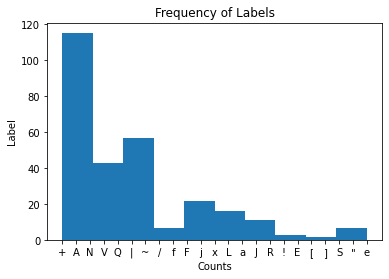

In [8]:
plt.hist(df.sym)
plt.title('Frequency of Labels')
plt.xlabel('Counts')
plt.ylabel('Label')

Graph doesn't seem to line up with tabular data below
[] Find out why not

In [9]:
df.groupby('sym').val.sum().sort_values(ascending = False)


sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

This dataset is extensively labelled with various abnormalities given their own names and labels. For the initial model, I will only use a boolean 0/1 to represent normal/abnormal. Later iterations may attempt to no only identify anomalies, but provide proposed labels naming the specific anomaly type, but that is beyond the scope of the current work.

Some of the abnormal labels also apply to features that aren't part of the normal heartbeat / cardiac cycle. I will focus on the actual abnormal beat features, not these "nonbeat" features.

In [10]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [11]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [12]:
df.groupby('cat').val.sum()


cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [13]:
df.head()

,sym,val,pt,cat
0,+,1,100,-1
1,A,33,100,1
2,N,2239,100,0
3,V,1,100,1
0,+,1,101,-1


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([ 40. ,  48.4,  56.8,  65.2,  73.6,  82. ,  90.4,  98.8, 107.2,
        115.6, 124. ]),
 <BarContainer object of 10 artists>)

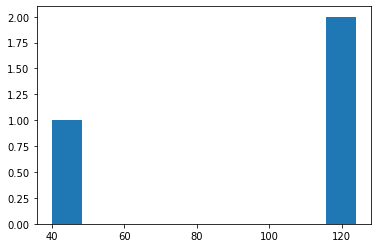

In [14]:
plt.hist(df.cat.value_counts())

This gives me an overall dataset of 75052 normal cardiac cycles, 34409 examples of abnormalities, and 3186 non-beat features which will be excluded from training and modeling.

The following function will load a single patient's signals and annotations (annotation values are the indices of the signal array)

In [15]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

In [16]:
# Files are named by patient number, already listed in the pts array, in the path defined
file = data_path + pts[0]


In [17]:
p_signal, atr_sym, atr_sample = load_ecg(file)


In [18]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)


+ 3
J 50
N 2700
V 3
~ 8


It is important to note that the data do not contain 'normal' ECGs for 'normal' patients and 'abnornal' ecgs for 'abnormal' patients.

For any given patient over the recording period, there will be many 'normal' beats and possibly 'abnormal' ones as well.

In [19]:
# Get index of any abnormal beats
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

This is time-based data with a sample frequency of 360 Hz. I do not have a time-stamp in the dataframe, but we can make an x-array of the length of the signal values to serve as our time axis since the time sampling interval is regular each value is (1/360) seconds.

In [20]:
x = np.arange(len(p_signal))


Here, I will plot an abnormal beat from our abnormal index and show 3 seconds before and after the abnormality

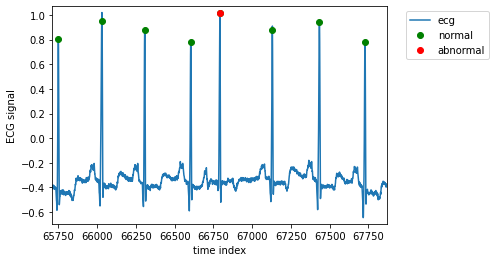

In [21]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()


## Dataset Generation

Here, I will make a dataframe containing every heartbeat in the dataset centered on the beat with the 3 seconds before and after, like the example above.

In [22]:
def make_dataset(pts, num_sec, fs, abnormal):
    '''
    function for making dataset ignoring non-beats
    
    input:
        pts - list of patients
        num_sec = number of seconds to include before and after the beat
        fs = frequency
    
    output: 
        X_all = signal (nbeats , num_sec * fs columns)
        Y_all = binary is abnormal (nbeats, 1)
        sym_all = beat annotation symbol (nbeats,1)
    '''

    #initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    #list to keep track of number of beats across patients
    max_rows = []
        
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all

In [23]:
def build_XY(p_signal, df_ann, num_cols, abnormal):
    '''
    this function builds the X,Y matrices for each beat
     it also returns the original symbols for Y
    '''
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym
    

In [24]:
# define parameters
num_sec = 3
fs = 360

In [25]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

The previous cell took minutes to run, so I will convert X_all, Y_all, and sym_all to dataframes and cache them as CSV files (which I wont upload to Github this time as they are too large)

In [26]:
X_all=pd.DataFrame(X_all)
Y_all=pd.DataFrame(Y_all)
sym_all=pd.DataFrame(sym_all)

In [27]:
#X_all_df=pd.DataFrame(X_all)
#Y_all_df=pd.DataFrame(Y_all)
#sym_all_df=pd.DataFrame(sym_all)

In [28]:
X_all.head()

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-0.340,-0.335,-0.330,-0.35,-0.350,-0.345,-0.335,-0.335,-0.335,-0.350,...,-0.365,-0.375,-0.370,-0.365,-0.360,-0.355,-0.360,-0.360,-0.350,-0.34
1,-0.390,-0.395,-0.410,-0.40,-0.390,-0.390,-0.385,-0.405,-0.415,-0.415,...,-0.340,-0.335,-0.330,-0.335,-0.345,-0.350,-0.350,-0.340,-0.335,-0.33
2,-0.400,-0.410,-0.425,-0.41,-0.405,-0.395,-0.400,-0.400,-0.405,-0.385,...,-0.340,-0.320,-0.315,-0.330,-0.340,-0.340,-0.350,-0.330,-0.330,-0.34
3,-0.405,-0.410,-0.405,-0.40,-0.390,-0.395,-0.410,-0.415,-0.410,-0.395,...,-0.270,-0.265,-0.260,-0.275,-0.285,-0.265,-0.255,-0.250,-0.270,-0.28
4,-0.470,-0.455,-0.460,-0.44,-0.435,-0.425,-0.430,-0.445,-0.450,-0.445,...,-0.320,-0.310,-0.300,-0.295,-0.300,-0.315,-0.325,-0.325,-0.305,-0.31


In [29]:
X_all.shape

(109099, 2160)

In [30]:
Y_all.head()

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


In [31]:
Y_all.shape

(109099, 1)

In [32]:
# X_all_df.to_csv('X_all.csv')
# Y_all_df.to_csv('Y_all.csv')
# sym_all_df.to_csv('sym_all.csv')

### Split Data

In [33]:
from sklearn.model_selection import train_test_split


In [34]:
def split_my_data(X_all, Y_all, sym_all, pct=0.10):
    '''
    This splits a dataframe into train, validate, and test sets. 
    df = dataframe to split
    pct = size of the test set, 1/2 of size of the validate set
    Returns three dataframes (train, validate, test)
    '''
    X_train_validate, X_test, Y_train_validate, Y_test, sym_train_validate, sym_test = train_test_split(
        X_all, Y_all, sym_all, test_size=pct, random_state=123)
    X_train, X_validate, Y_train, Y_validate, sym_train, sym_validate = train_test_split(
        X_train_validate, Y_train_validate, sym_train_validate, test_size=pct*2, random_state=123)
    return X_train, X_validate, X_test, Y_train, Y_validate, Y_test, sym_train, sym_validate, sym_test

In [36]:
#X_all

In [37]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test, sym_train, sym_validate, sym_test = split_my_data(X_all, Y_all, sym_all)

In [38]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

(78551, 2160)
(19638, 2160)
(10910, 2160)


In [39]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
39859,-1.365,-1.365,-1.365,-1.385,-1.395,-1.415,-1.435,-1.46,-1.460,-1.485,...,-0.945,-0.935,-0.895,-0.895,-0.885,-0.875,-0.875,-0.870,-0.865,-0.860
35749,-0.920,-0.910,-0.905,-0.895,-0.870,-0.880,-0.900,-0.90,-0.905,-0.905,...,-0.825,-0.810,-0.805,-0.800,-0.815,-0.820,-0.820,-0.815,-0.820,-0.825
96921,-0.405,-0.455,-0.455,-0.445,-0.410,-0.380,-0.345,-0.32,-0.260,-0.215,...,-0.280,-0.280,-0.265,-0.270,-0.260,-0.285,-0.275,-0.275,-0.265,-0.255
63295,1.245,1.265,1.235,1.135,0.985,0.760,0.485,0.25,0.045,-0.115,...,-0.345,-0.325,-0.320,-0.325,-0.335,-0.370,-0.360,-0.350,-0.335,-0.340
80479,-0.260,-0.240,-0.240,-0.270,-0.285,-0.280,-0.270,-0.26,-0.255,-0.270,...,0.135,0.110,0.085,0.055,0.025,0.005,-0.035,-0.070,-0.070,-0.095


In [40]:
Y_train.head()

,0
39859,0.0
35749,0.0
96921,0.0
63295,0.0
80479,0.0


Some of the keras / tensor flow modeling things require np arrays, other aspects of exploring and plotting are easier with dataaframes, so maintaining both.

In [ ]:
#X_train_df=pd.DataFrame(X_train)
#X_validate_df=pd.DataFrame(X_validate)
#X_test_df=pd.DataFrame(X_test)

#Y_train_df=pd.DataFrame(Y_train)
#Y_validate_df=pd.DataFrame(Y_validate)
#Y_test_df=pd.DataFrame(Y_test)

#sym_train_df=pd.DataFrame(sym_train)
#sym_validate_df=pd.DataFrame(sym_validate)
#s.ym_test_df=pd.DataFrame(sym_test)

In [41]:
print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)

(78551, 1)
(19638, 1)
(10910, 1)


In [ ]:
#X_train.to_csv('X_train.csv')
#X_validate.to_csv('X_validate.csv')
#X_test.to_csv('X_test.csv')

In [ ]:
#Y_train.to_csv('Y_train.csv')
#Y_validate.to_csv('Y_validate.csv')
#Y_test.to_csv('Y_test.csv')

In [ ]:
#sym_train.to_csv('sym_train.csv')
#sym_validate.to_csv('sym_validate.csv')
#sym_test.to_csv('sym_test.csv')

In [42]:
Y_all.head()

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


In [43]:
sym_all.head()

,0
0,N
1,N
2,N
3,A
4,N


Concatenate the Y_train target back on the X_train datasets so I can segregate normal / abnormal for exploration

In [ ]:
X_explore_df = X_train
X_explore_df['abnormal']=Y_train
X_explore_df['sym']=sym_train


In [ ]:
X_explore_df.sample(25)

In [ ]:
X_explore_normal = X_explore_df[X_explore_df.abnormal==0]

In [ ]:
X_explore_normal.shape

In [ ]:
X_explore_abnormal = X_explore_df[X_explore_df.abnormal==1]

In [ ]:
X_explore_abnormal.shape

Look at individual traces

Three sample normal

In [ ]:
X_explore_normal.shape

In [ ]:
X_explore_normal.sample(20)

In [ ]:
plt.plot(np.arange(2161), X_explore_normal.iloc[0]);

In [ ]:
plt.plot(np.arange(2161), X_explore_normal.iloc[1]);

In [ ]:
plt.plot(np.arange(2161), X_explore_normal.iloc[2]);

3 sample abnormal

In [ ]:
plt.plot(np.arange(2161), X_explore_abnormal.iloc[0]);

In [ ]:
plt.plot(np.arange(2161), X_explore_abnormal.iloc[1]);

In [ ]:
plt.plot(np.arange(2161), X_explore_abnormal.iloc[2]);

---

### Literature / Curriculum / Research Review

- Now that I have my data in a usable format, I need to do some research on time series and anomaly detection in order to get into the modeling phase.

**Topics to explore:**
- [] Anomaly Detection
- [] LSTM Networks - this concept comes up a lot in handling these data
- [] Autoencoders
- [] CNN? Neural networks are also commonly used for processing these types of data. Will start with other techniques and may get here in a subsequent iteration

### Anomaly Detection

- Task of determining when something has gone astray from the norm. 
  - Neural networks are used for unsupervised learning (I do have labels, so I should take advantage of those)
  - Basically just learns the normal behavior and anything that isn't that gets labeled as an anomaly.
  - i.e., autoencoder deep learning neural network

### LSTM Networks

- Long Short-Term Memory neural network cells in autoencoder. 
- Subset of recurrent neural networks (RNN).
- Training data persists in network for use later   
  - Well-suited for temporal data that evolves over time
- Common applications include:
  - Speech recognition
  - Text translation
  - Analysis of sequential sensor readings for anomaly detection

### Recurrent Neural Networks (2)

- Networks with loops in them allowing information to persist.
- Able to use "reasoning" about previous events to make decisions.

![RNN](images/RNN1.png)
**Recurring Neural Networks have loops**

These loops can be thought of as multiple copies of the same network

![RNN unwound](images/RNN2.png)

2. https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Problem of Long-Term Dependencies

- Appeal of RNN is to connect previous information to the present task.
- Sometimes we only need to look at recent information. i.e., language model trying to predict the next word based on previous ones. If trying to predict "the clouds are in the ___" we don't need any further context - small gap between relevant information and the place it is needed.
  
  ![RNN-short-dependencies](images/RNN3.png)

- Other times, more context is needed. "I grew up in France...I speak fluent ____" Recent information suggest the name of a language for the answer, but to get which language more context from earlier is needed. The gab between the relevant information and the point it is needed can be quite large. 

![RNN-long-dependencies](images/RNN4.png)

- RNNs struggle as that gap grows.
- RNNs theoretically capable of hangling such long dependencies, but fail to do so in practice. LTSMs don't have this problem

### LSTM Networks

- Special kind of RNN capable of learning long-term dependencies
- Explicitly designed to avoid long-term dependency problem. Remembering information for long periods of time is their default behavior, not something they struggle to learn.
- Standard RNN:

![RNN-standard-single-layer](images/RNN4.png)

- LSTM module has 4 interacting layers

![LSTM](images/LSTM1.png)

![LSTM-layers](images/LSTM2.png)

#### Core Concept

- **Cell State:** Horizontal line running through the top of the diagram.
- Kind of like a conveyor belt - straight down the entire chain with only minor interactions. Easy for information to flow along unchanged.
- There is the ability to remove or add information to the cell state, but it is carefully regulated by gates which let ingotmation through
  - Composed of sigmoid layers and pointwise multiplication:
    - 0 - let nothing through
    - 1 - let everything through
  - LSTM has three of these gates to protect and control the cell state.
  
![LSTM-gate](images/gate.png)


### LSTM: Step by step

1. Decide that information we are going to throw away from the cell state
   - "Forget gate layer" outputs a number between 0 and 1 keep / get rid of
2. Decide what new information to store
    1. "Input gate layer" decides which values to update
    2. Tanh layer creates vector of new candidate values that could be added to the state
3. Update cell state
    - Forget what decided to forget
    - Add scaled candidate values
4. Decide output based on cell state

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

---

### Review Codeup Curriculum on Anomaly Detection

- Practice of identifying data points, items, observations, or events that do not conform to the expected pattern of a given group

#### What are Anomalies?

- **Anomaly**: Unusual, unexpected, surprising patterns in the observed rule. An anomalous data point is a deviation from a rule or from what is regarded as normal; an outlier. An anomaly is any event or measurement that is out of the ordinary regardless of whether it is exceptional or not.


- **Outlier**: An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. In a sense, this definition leaves it up to the analyst (or a consensus process) to decide what will be considered abnormal. Before abnormal observations can be singled out, it is necessary to characterize normal observations.


- These terms are frequently used interchangeably.


- In some cases, statisticians sometimes use the term 'outlier' to mean "something I should remove from the dataset so that it doesn't skew my model I'm building".


- In other cases, we may reserve the word 'anomaly' for data points we want to keep because they are valuable if caught or costly if missed. It's also possible to have an anomaly that is an inlier, meaning that the data is anomalous in nature but is close (in distance) to the mean, mode, or expected grouping(s).

<h2 id="examples-of-anomaly-detection-in-data-science">Examples  of Anomaly Detection in Data Science</h2>
<ul>
<li>Fraud detection for financial companies</li>
<li>Medical scans like XRays, ultrasounds, and MRIs seeking abnormalities in location, density, growth, etc..</li>
<li>Detecting and preventing cyber-crime</li>
<li>Malware detection</li>
<li>Intelligence and Defense applications</li>
<li>Analytical Marketing looking for new trends in business or household purchases</li>
</ul>

<h2 id="the-best-way-to-detect-anomalies-is-to-know-your-domain">The <strong>best</strong> way to detect anomalies is to <em>know your domain</em></h2>
<ul>
<li>For example, knowing that there is nothing colder than absolute zero degrees Kelvin informs how we approach an observation below 0 degrees Kelvin. It may mean that there is something wrong with the measuring tool or a clerical error like a typo (more likely).</li>
<li>What determines if a data point is an outlier is a function of <strong>who</strong> determines if that data point is anomalous and <strong>why</strong>. </li>
<li>One person's noise is another person's signal, depending on their goals and the costs and benefits to be gained/avoided from identifying that data point.<ul>
<li>To one analyst aiming for a clean model of 50/50 chance, observing a flipped coin that lands exactly on its side is an anomaly may be noise that they should ignore from their model. </li>
<li>To another practitioner, the anomaly may be an observation of very high value that they want to catch, like early detection of a rare disease. </li>
</ul>
</li>
<li>Recall the <a href="https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm">e-Handbook of Statistical Methods</a> definition an outlier: "an observation that lies an abnormal distance from other values in a random sample from a population. <em>In a sense, this definition leaves it up to the analyst (or a consensus process) to decide what will be considered abnormal"</em>. </li>
<li>It's important to define the criteria, the decision rule, for what makes an observation an inlier or an outlier.</li>
<li>Usually, the deciding factor is cost/benefit analysis:<ul>
<li>Is our goal to hunt for anomalies at all costs because lives are on the line?</li>
<li>Or do we do more good for people by producing a model that treats outliers as noise?</li>
<li>What is the cost of a false positive or a false negative?</li>
<li>What is the benefit of a true positive or a true negative?</li>
</ul>
</li>
</ul>

<h2 id="outliers-may-contain-important-information">Outliers may contain important information</h2>
<p>Outliers should be investigated carefully. </p>
<p>Often they contain valuable information about the process under investigation or the data gathering and recording process. Before considering the possible elimination of these points from the data, one should try to understand why they appeared and whether it is likely similar values will continue to appear. Of course, outliers are often bad data points.</p>


<h2 id="types-of-anomalies">Types of Anomalies</h2>
<ul>
<li>
<p><strong>Use Cases:</strong> Response times (longer than usual), error rates (more than usual), network load, cyber intrusions, fraud.</p>
</li>
<li>
<p><strong>Point Anomalies:</strong>  A single instance of data is anomalous if it's too far off from the rest. For example, detecting data exfiltration based on gigabytes leaving the network, detecting credit card fraud based on "amount spent", etc.</p>
</li>
<li>
<p><strong>Contextual Anomalies:</strong> The abnormality is context specific. This type of anomaly is common in time-series data. For example, accessing confidential files during work hours is normal, but in the middle of the night is odd.</p>
</li>
<li>
<p><strong>Collective Anomalies:</strong>  A set of data instances collectively helps in detecting anomalies. For example, someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack. The combination of the event from the remote machine and the event from the local host combine to detect the anomaly.</p>
</li>
<li>
<p><strong>Anomalies vs. Noise Removal vs. Novelty Detection:</strong> Novelty detection is concerned with identifying an unobserved pattern in new observations not included in training data — for instance, a sudden interest in a new channel on YouTube during Christmas. Noise Removal (NR) is the process of immunizing analysis from the occurrence of unwanted observations; in other words, removing noise from an otherwise meaningful signal.</p>
</li>
</ul>
<p>https://www.datascience.com/blog/python-anomaly-detection</p>

<h2 id="specific-techniques-for-identifyingdetecting-anomalies">Specific Techniques for Identifying/Detecting Anomalies</h2>
<h3 id="statistical-methods">Statistical Methods</h3>
<ul>
<li>
<p>Flag the data points that deviate from the expected, based on the statistical properties, such as mean, median, mode, and quantiles. </p>
</li>
<li>
<p>You could define an anomalous data point as one that deviates by a certain standard deviation from the mean. </p>
</li>
<li>
<p>You could use a simple or exponential moving average to smooth short-term fluctuations and highlight long-term ones.</p>
</li>
<li>
<p>This method is challenging with really noisy data. </p>
</li>
</ul>
<h3 id="support-vector-machine-isolation-forest-anomaly-detection">Support Vector Machine &amp; Isolation Forest Anomaly Detection</h3>
<ul>
<li>
<p>There are extensions to the supervised technique, such as OneClassSVM, that can be used to identify anomalies as an unsupervised problems (in which training data are not labeled).</p>
</li>
<li>
<p>The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region.</p>
</li>
</ul>
<h3 id="clustering-based-anomaly-detection">Clustering-Based Anomaly Detection</h3>
<ul>
<li>
<p>Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.</p>
</li>
<li>
<p>K-means creates 'k' similar clusters of data points. Data instances that fall into abnormally small clusters could potentially be marked as anomalies.</p>
</li>
<li>
<p>Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.</p>
</li>
</ul>
<h3 id="density-based-anomaly-detection">Density-Based Anomaly Detection</h3>
<ul>
<li>
<p>Assumption: Normal data points occur around a dense neighborhood and abnormalities are far away.</p>
</li>
<li>
<p>The nearest set of data points are evaluated using a score, using one of two algorithms:</p>
<ul>
<li>KNN: K-Nearest Neighbor</li>
<li>LOF: Local Outlier Factor, aka the relative density of data which is based on the reachability distance.</li>
</ul>
</li>
</ul>

<h2 id="remember">Remember</h2>
<ul>
<li>There is not a magic algorithm that takes away our responsibility to think clearly and critically about <em>why</em> an observation is anomalous.</li>
<li>There are no hard fast rules for whether or not an outlier should be ignored or investigated.</li>
<li>The answer is "it depends", and the important part is identifying what that depends on, specifically.</li>
</ul>

<h2 id="further-resources">Further Resources</h2>
<ul>
<li><a href="https://www.youtube.com/watch?v=086OcT-5DYI">Video overview of anomaly detection from Andrew Ng</a></li>
<li><a href="https://scikit-learn.org/stable/modules/outlier_detection.html">SKLearn Examples of Outlier Detection</a></li>
<li>Additional <a href="https://github.com/yzhao062/anomaly-detection-resources">Anomaly Detection Resources</a></li>
<li><a href="https://github.com/yzhao062/pyod">Python Toolbox for Scalable Outlier Detection</a></li>
</ul>

---

Doesn't appear to be any LSTM / CNN resources in the curriculum or appendix, so - back to the web!

### Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/



- Discover how to develop LSTM networks in Python using the Keras deep learning library to address a demonstration time-series prediction problem.
- 

---

In [ ]:
#!keras --version

In [ ]:
# from keras.layers import Bidirectional, LSTM


In [ ]:
# from keras.models import Sequential
#from keras.layers import Dense, Flatten, Dropout
#from keras.utils import to_categorical

In [ ]:
# reshape input to be [samples, time steps, features = 1]
#X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

#print(X_train_cnn.shape)
#print(X_valid_cnn.shape)

In [ ]:
#model = Sequential()
#model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
#model.add(Dropout(rate = 0.25))
#model.add(Dense(1, activation = 'sigmoid'))
#model.compile(
#                loss = 'binary_crossentropy',
#                optimizer = 'adam',
#                metrics = ['accuracy'])


---

So, something about keras was breaking my Jypyter kernel. And, the LSTM modeling was more involved than I anticipated it being, so... I am shifting gears and focus to do random forrest classification of these data using the labeled traces.

Previously, I was maintaining parallel numpy arrays and dataframes for my data since different things I was doing eat either one (likely an unnecessary step as I could intervonvert from one to the other as needed simply, but oh well).

Before proceeding with Random Forrest modeling, I will verify my X/Y train / validate/ test dataframes appear as they should

In [ ]:
X_train.sample(20)

It does have the target, wich it should not

In [ ]:
Y_train

In [ ]:
print(X_train.shape)

In [ ]:
Y_train.shape

It is no longer neccessary to have the np arrays, so I will just overwrite them with the dataframes to have X_train instead of X_train_df, since some of my other modeling and evaluation functions are already written with these variables.

In [44]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print()
print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)
print()
print(sym_train.shape)
print(sym_validate.shape)
print(sym_test.shape)

(78551, 2160)
(19638, 2160)
(10910, 2160)

(78551, 1)
(19638, 1)
(10910, 1)

(78551, 1)
(19638, 1)
(10910, 1)


Okay... have my data split. On to modeling

---

## Modeling

As mentioned above, the state of the art for modeling these data is using neural networks, specifically the LSTM subset of RNNs. I will revisit this as a future direction. 

In the absence of neural networks, random forrest classifiers often perform the best of the simpler techniques. Will make and tune multiple random forrest models and try the lazy classifier as well

In [ ]:
#from lazypredict.Supervised import LazyClassifier, LazyRegressor
